In [1]:
import torch
import torch.nn as nn

In [2]:
class TokenAndPositionEmbedding(nn.Module):
  def __init__(self, vocab_size, embedding_dim, max_len, device = 'cpu'):
    super().__init__()
    self.device = device
    self.word_emb = nn.Embedding(vocab_size, embedding_dim)
    self.pos_emb = nn.Embedding(max_len, embedding_dim)

  def forward(self, x):
    N, seq_len = x.size() # với N là số lượng batch, seq_len là độ dài của một chuỗi token
    # tạo một ma trận vị trí cho các chuỗi token
    positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
    output1 = self.word_emb(x) # embeding các phần tử
    output2 = self.pos_emb(positions)
    return output1 + output2

### Xây dựng Transformer block




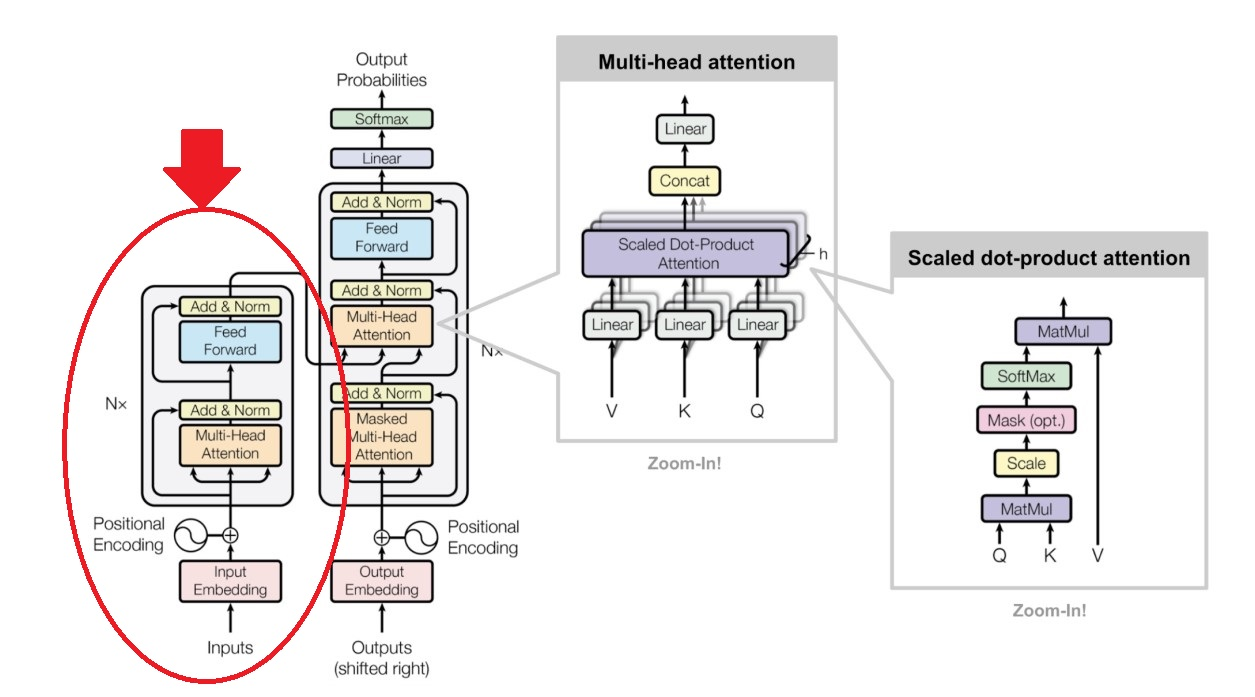

In [3]:
# encoder
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
    super().__init__()
    self.attn = nn.MultiheadAttention(
        embed_dim = embed_dim,
        num_heads = num_heads,
        dropout = dropout
    )
    # tạo một lớp feed forward để tăng khả năng biểu diễn phi tuyến
    # và cải thiện hiệu xuất huấn luyện
    self.ffn = nn.Sequential(
        nn.Linear(embed_dim, ff_dim, bias = True),
        nn.ReLU(),
        nn.Linear(ff_dim, embed_dim, bias = True)
    )
    self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps = 1e-6)
    self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps = 1e-6)
    self.dropout_1 = nn.Dropout(dropout)
    self.dropout_2 = nn.Dropout(dropout)

# xây dựng mô hình tương tự như ảnh
  def forward(self, query, key, value):
    attn_out, _ = self.attn(query, key, value)
    attn_out = self.dropout_1(attn_out)
    # Residual Connection and layernorm
    out1 = self.layernorm_1(query + attn_out)
    ffn_out = self.ffn(out1)
    ffn_out = self.dropout_2(ffn_out)
    # Residual Connection and layernorm
    out2 = self.layernorm_2(out1 + ffn_out)
    return out2

**Tại sao đầu ra của hàm ```forward()``` lại lấy mỗi layer cuối cùng trong vòng lặp?**


*   **Luồng dữ liệu:**
    * Dữ liệu đi qua từng lớp từ **lớp đầu tiên cho đến lớp cuối cùng**.
    * Đầu ra của lớp trước là đầu vào của lớp tiếp theo:
    
    ```python
for layer in self.layer:
        x = layer(x, x, x)
    ```
    * Ở đây, đầu vào ```x``` được truyền qua tất cả các lớp.
    * Lớp cuối cùng nhận được kết quả từ lớp ngay trước nó, nhưng đặc trưng của lớp cuối cùng đã được **xây dựng dựa trên kết quả tích lũy từ tất cả các lớp trước đó**.

In [4]:
class TransformerEncoder(nn.Module):
  def __init__(self, scr_vocab_size, embed_dim, max_len, num_heads,
               ff_dim, num_layers, dropout=0.1, device = 'cpu'):
    super().__init__()
    self.embedding = TokenAndPositionEmbedding(scr_vocab_size,  embed_dim,
                                               max_len, device = 'cpu')
    self.layer = nn.ModuleList([
        TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout)
        for _ in range(num_layers)
    ])

  def forward(self, x, mask = None):
    x = self.embedding(x)
    for layer in self.layer:
      # phần này chạy theo hàm forward trong TransformerEncoderBlock
      # xem như phần query, key, value
      x = layer(x, x, x)
    return x


## Xây dựng decoder block

In [5]:
class TransformerDecoderBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
    super().__init__()
    self.attn = nn.MultiheadAttention(
        embed_dim = embed_dim,
        num_heads = num_heads,
        dropout = dropout
    )
    self.cross_attn = nn.MultiheadAttention(
        embed_dim = embed_dim,
        num_heads = num_heads,
        dropout = dropout
    )
    self.ffn = nn.Sequential(
        nn.Linear(embed_dim, ff_dim, bias = True),
        nn.ReLU(),
        nn.Linear(ff_dim, embed_dim, bias = True)
    )
    self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps = 1e-6)
    self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps = 1e-6)
    self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps = 1e-6)
    self.dropout_1  = nn.Dropout(dropout)
    self.dropout_2  = nn.Dropout(dropout)
    self.dropout_3  = nn.Dropout(dropout)

  def forward(self, x, enc_output, src_mask, tgt_mask):
    attn_out, _ = self.attn(query = x, key = x, value = x, attn_mask = tgt_mask)
    attn_out = self.dropout_1(attn_out)
    out_1 = self.layernorm_1(x + attn_out)

    attn_output, _ = self.cross_attn(query = out_1, key = enc_output, value = enc_output, attn_mask = src_mask)
    attn_output = self.dropout_2(attn_output)
    out_2 = self.layernorm_2(out_1 + attn_output)

    ffn_output = self.ffn(out_2)
    ffn_output = self.dropout_3(ffn_output)
    out_3 = self.layernorm_3(out_2 + ffn_output)

    return out_3



**Tại sao đầu ra của hàm ```forward()``` lại lấy mỗi layer cuối cùng trong vòng lặp?**


*   **Luồng dữ liệu:**
    * Dữ liệu đi qua từng lớp từ **lớp đầu tiên cho đến lớp cuối cùng**.
    * Đầu ra của lớp trước là đầu vào của lớp tiếp theo:
    
    ```python
for layer in self.layer:
        x = layer(x, x, x)
    ```
    * Ở đây, đầu vào ```x``` được truyền qua tất cả các lớp.
    * Lớp cuối cùng nhận được kết quả từ lớp ngay trước nó, nhưng đặc trưng của lớp cuối cùng đã được **xây dựng dựa trên kết quả tích lũy từ tất cả các lớp trước đó**.

In [6]:
class TransformerDecoder(nn.Module):
  def __init__(self, tgt_vocab_size, embed_dim, max_len,
               num_layers, num_heads, ff_dim, dropout = 0.1, device = 'cpu' ):
    super().__init__()
    self.embedding = TokenAndPositionEmbedding(tgt_vocab_size, embed_dim, max_len, device = 'cpu')

    self.layers = nn.ModuleList([
        TransformerDecoderBlock(embed_dim, num_heads, ff_dim, dropout)
        for _ in range(num_layers)
    ])

  def forward(self, x, enc_output, src_mask, tgt_mask):
    x = self.embedding(x)
    for layer in self.layers:
      x = layer(x, enc_output, src_mask, tgt_mask)
    return x

### Xây dựng transformer

In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, max_len,
               num_layers, num_heads, ff_dim, dropout = 0.1, device = 'cpu'):
    super().__init__()
    self.device =  device
    self.encoder = TransformerEncoder(src_vocab_size, embed_dim, max_len, num_layers, num_heads, ff_dim, dropout, device)
    self.decoder = TransformerDecoder(tgt_vocab_size, embed_dim, max_len, num_layers, num_heads, ff_dim, dropout, device)
    self.linear = nn.Linear(embed_dim, tgt_vocab_size)

  def generate_mask(self, src, tgt):
      src_seq_len = src.shape[1]
      tgt_seq_len = tgt.shape[1]

      src_mask = torch.zeros((src_seq_len, src_seq_len)).to(self.device).type(torch.bool)

      # Create a default target mask assuming no padding
      tgt_mask = (torch.triu(torch.ones((tgt_seq_len, tgt_seq_len))) == 1).transpose(0,1)
      tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))

      # OR
      # If you have padding, you'll need to create the mask based on tgt values
      # For example, if padding is represented by 0:
      # tgt_mask = (tgt != 0).unsqueeze(1) # Create mask based on non-zero elements
      return src_mask, tgt_mask

  def forward(self, src, tgt):
    src_mask, tgt_mask = self.generate_mask(src, tgt)
    enc_output = self.encoder(src, src_mask)
    dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
    output = self.linear(dec_output)
    return output

: 

In [ ]:
# Thử nghiệm
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

model = Transformer(
    src_vocab_size, tgt_vocab_size,
    embed_dim, max_length, num_layers, num_heads, ff_dim
)

src = torch.randint(
    high=src_vocab_size,
    size=(batch_size, max_length),
    dtype=torch.int64
)

tgt = torch.randint(
    high=tgt_vocab_size,
    size=(batch_size, max_length),
    dtype=torch.int64
)

prediction = model(src, tgt)
prediction.shape  # batch_size x max_length x tgt_vocab_size
